In [1]:
# LSTM 单层 LSTM 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt

In [3]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

# np.random.seed(1027)
# torch.manual_seed(1027)
# torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)

In [5]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.7
TRAIN_BATCH_SIZE = 20                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 20
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int((rolling_data.shape[0]//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int((rolling_data.shape[0]//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (644, 20, 135)
seq count: 644
seq length: 20
TRAIN_BATCH_COUNT : 22
VALID_BATCH_COUNT : 10
TEST_BATCH_COUNT  : 1
train_x: torch.Size([22, 20, 20, 134])
train_y: torch.Size([22, 20, 1, 1])
valid_x: torch.Size([10, 20, 20, 134])
valid_y: torch.Size([10, 20, 1, 1])
test_x:  torch.Size([1, 4, 20, 134])
test_y:  torch.Size([1, 4, 1, 1])
train_batch_count: 22
valid_batch_count: 10
test_batch_count:  1


In [32]:
# 定义 LSTM 模型

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, attention_size=5, dropout=0):
        super().__init__()
        self.hidden_size = hidden_layer_size
        self.sequence_length = SEQ_LENGTH
        self.attention_size = attention_size
        self.num_layers = num_layers
        self.attention_size = attention_size        
        
        self.dropout = nn.Dropout(dropout)
        
        self.lstm1 = nn.LSTM(input_size=input_size,        hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=hidden_layer_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.linear_1 = nn.Linear(hidden_layer_size, int(hidden_layer_size/4))
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)
        
        
        # self.h10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)*num_layers).double().to(device)
        # self.c10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)*num_layers).double().to(device)
        # self.h20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size*num_layers).double().to(device)
        # self.c20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size*num_layers).double().to(device)
        
        
        # w_omega means W_w
        # u_omega means U_w
        self.w_omega = Variable(torch.zeros(self.hidden_size, self.attention_size).double().to(device))
        self.u_omega = Variable(torch.zeros(self.attention_size).double().to(device))
        
        self.init_weights3()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
                
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    def init_weights4(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=0, std=1)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=0, std=1)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    
    def attention_net(self, lstm_output, query, mask=None):
        # print(lstm_output.size())                                                   # [batch_size, seq_len, hidden_dim_size]
        # print(query.size())                                                         # [batch_size, seq_len, hidden_dim_size]
        # k = lstm_output.dropout()
        # q = lstm_output.transpose(1,2)
        # v = lstm_output
        d_k = query.size(-1)                                                        # d_k为query的维度
        scores = torch.matmul(query, lstm_output.transpose(1, 2)) / math.sqrt(d_k)  #打分机制  [batch_size, seq_len, hid_dim] * [batch_size, hid_dim, seq_len] ==> scores:[batch_size, seq_len, seq_len], 每个值就是两个输入x元素的相似性

        p_attn = F.softmax(scores, dim = -1)                                        #对最后一个维度归一化得分  [batch_size, seq_len, seq_len] 保证相似性在一行上归一了。

        context = torch.matmul(p_attn, lstm_output)                                 #对权重化的x求和，[batch_size, seq_len, seq_len] * [batch, seq_len, hidden_dim] ==> [batch_size, seq_len, hidden_dim_size]
        # print(context.shape)
        
        context = torch.matmul(p_attn, lstm_output).sum(1)                          #对权重化的x求和，[batch_size, seq_len, seq_len] * [batch, seq_len, hidden_dim] ==> [batch_size, hidden_dim_size]
        # print(context.shape)
        return context, p_attn      
        
    
    def forward(self, x, hidden, cell):

        
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).double().to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).double().to(device)
        
        # x = self.dropout(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        

        lstm_out, (h_n, c_n) = self.lstm1(x, (h0.detach(), c0.detach()))
        
        # lstm_out, (h_n, c_n) = self.lstm1(x, (hidden, cell))
                
        # lstm1_out = self.dropout(lstm1_out)
                
        # lstm_out, (h2_n, c2_n) = self.lstm2(lstm1_out, (h1_n.detach(), c1_n.detach()))
        # lstm_out, (h2_n, c2_n) = self.lstm2(lstm1_out, (h1_n.detach(), c1_n.detach()))
        lstm_out, (h2_n, c2_n) = self.lstm2(lstm_out, (h_n.detach(), c_n.detach()))
        
        # lstm_out, (h2_n, c2_n) = self.lstm1(x, (hidden, cell))
        
        query = self.dropout(lstm_out)

        attn_output, attention = self.attention_net(lstm_out, query)       #和LSTM的不同就在于这一句
        
        predictions = self.linear_2(attn_output)
        
        return predictions, h2_n, c2_n


In [69]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 512
NUM_LAYERS = 2

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

model = LSTMModel(input_size=X_DIM, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-6
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

0 of 500 epoch   train_loss: 8.5753   valid_loss: 7.3709
1 of 500 epoch   train_loss: 8.5412   valid_loss: 7.3390
2 of 500 epoch   train_loss: 8.5071   valid_loss: 7.3067
3 of 500 epoch   train_loss: 8.4723   valid_loss: 7.2737
4 of 500 epoch   train_loss: 8.4366   valid_loss: 7.2397
5 of 500 epoch   train_loss: 8.3996   valid_loss: 7.2043
6 of 500 epoch   train_loss: 8.3610   valid_loss: 7.1670
7 of 500 epoch   train_loss: 8.3202   valid_loss: 7.1276
8 of 500 epoch   train_loss: 8.2768   valid_loss: 7.0857
9 of 500 epoch   train_loss: 8.2305   valid_loss: 7.0406
10 of 500 epoch   train_loss: 8.1806   valid_loss: 6.9919
11 of 500 epoch   train_loss: 8.1265   valid_loss: 6.9389
12 of 500 epoch   train_loss: 8.0674   valid_loss: 6.8808
13 of 500 epoch   train_loss: 8.0024   valid_loss: 6.8168
14 of 500 epoch   train_loss: 7.9306   valid_loss: 6.7458
15 of 500 epoch   train_loss: 7.8506   valid_loss: 6.6665
16 of 500 epoch   train_loss: 7.7610   valid_loss: 6.5774
17 of 500 epoch   train_

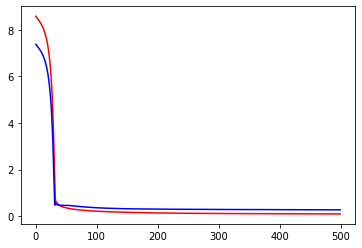

In [70]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 200
train_epoch_loss = 0
train_epoch_loss_list = []
valid_smallest_loss = 1
valid_smallest_epoch = 0
valid_epoch_loss = 0
valid_epoch_loss_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)

# h0 = torch.randn(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
# c0 = torch.randn(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)

for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    train_epoch_loss = np.mean(batch_loss)

    batch_loss = []
    valid_epoch_loss = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:,-1], valid_y[step][:,-1,-1])
        valid_pred_value_list.extend(list(valid_pred[:,-1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
        
    print("{} of {} epoch   train_loss: {:.4f}   valid_loss: {:.4f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))

    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()    

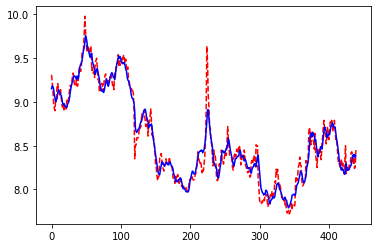

In [71]:
plt.plot(train_real_value_list, 'r--')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

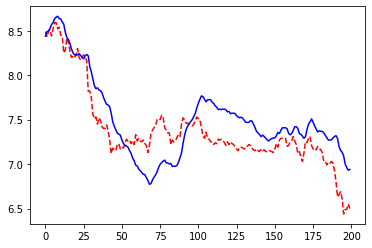

In [72]:
plt.plot(valid_real_value_list, 'r--')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

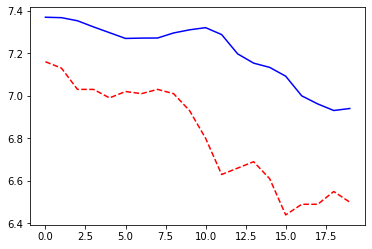

[7.16 7.13 7.03 7.03 6.99 7.02 7.01 7.03 7.01 6.93 6.8  6.63 6.66 6.69
 6.61 6.44 6.49 6.49 6.55 6.5 ]
[7.36910827 7.36716546 7.3525744  7.32377152 7.29659325 7.26943516
 7.27110218 7.27147562 7.2951661  7.3100057  7.3201669  7.28774029
 7.19699105 7.15334267 7.13342427 7.09196906 6.99964645 6.96164023
 6.93077199 6.94016891]


In [73]:
# 这是 valid 最后一段的数据。误差累积到这里以及很大了。
plt.plot(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
plt.plot(valid_pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy())
print(valid_pred[:,-1].cpu().detach().flatten().numpy())

Test Loss : 0.599909
Prediction: 7.14
Actual:     6.51


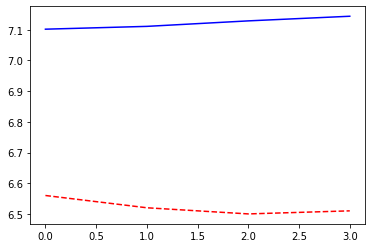

tensor([6.5600, 6.5200, 6.5000, 6.5100], device='cuda:0', dtype=torch.float64)
tensor([7.1017, 7.1108, 7.1287, 7.1438], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


In [60]:
# 用模型预测数据
# 考虑到时序因素，这里的时候误差很大。
model.eval()
test_loss = 0

h0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).double().to(device)

for step in range(test_x.shape[0]):
    pred, hn, cn = model(test_x[step], h0, c0)
    
    loss = loss_func(pred[:,-1], test_y[step][:,-1,-1])               # Compare the all sequences' last element in one batch
    
    if test_x.shape[1] == 1:
        actual_line.append(test_y[step][-1,-1].item())
        pred_line.append(pred[-1,-1].item())
    elif test_x.shape[1] > 1:
        actual_line = test_y[step].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
        pred_line   = pred[:,-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
        
print("Test Loss : {:.6f}".format(loss.data))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))


plt.plot(test_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
plt.plot(pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(test_y[step,:,-1,-1])
print(pred[:,-1])

In [94]:
# 把rolling_data再分割为 train / test 就再预测
# 既然 预测值 和时序相关性很高，可以考虑太早的零星数据对于test影响不大，可以删掉

rolling_data = rolling_data[0: ((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE+1,]
print(rolling_data.shape)

train = rolling_data[:-1].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-1:].reshape(1, 1, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train).to(device)
test  = torch.tensor(test).to(device)

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(641, 20, 135)
torch.Size([32, 20, 20, 134]) torch.Size([32, 20, 1, 1])
torch.Size([1, 1, 20, 134]) torch.Size([1, 1, 1, 1])


8.407066180621335
8.369694810957022
8.33073964864126
8.289715813113434
8.246182135111374
8.19965778959803
8.149599667670502
8.095384947718829
8.036294860714044
7.971495783013268
7.9000143794024265
7.820705514282749
7.732211214220592
7.632906104030393
7.520823431316953
7.393555566557734
7.248120312205845
7.080779868021613
6.886793733647988
6.66007705500825
6.392715580403631
6.074254257641323
5.690626467193133
5.222510322642744
4.642734359607354
3.9225247671063244
3.0558106932661264
2.0429471986380574
0.9425909345220757
0.5720500809027196
0.51068572485768
0.5062353981199904
0.47552005045871754
0.4615190621764144
0.447794125437347
0.43608187183960717
0.42612078302635065
0.41678195905764537
0.40824440980253224
0.4003652801576374
0.39308193286202914
0.38631692332466566
0.3800106921397722
0.3741096244567015
0.3685667826885057
0.3633406255279788
0.3583945416394793
0.3536964323596845
0.3492183341580618
0.3449360054352545
0.3408112474304828
0.33685041316094505
0.33304061065910157
0.329369050196

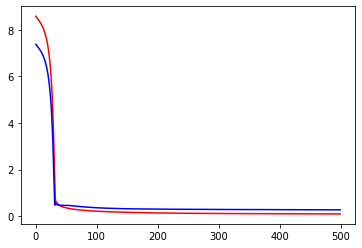

In [98]:
# 再重新 train 模型
model.train()

for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    print(np.mean(batch_loss))
    train_epoch_loss = np.mean(batch_loss)
    
plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()    

In [107]:
print(train_x[-1,-1])
print(train_y[-1,-1])
pred, hn, cn = model(test_x[-1], h0, c0)
print(pred)

tensor([[ 7.1800, -0.8659, -0.4620,  ..., -0.5246, -0.5819, -0.6422],
        [ 7.1600, -0.9324, -0.4620,  ..., -0.5246, -0.5932, -0.7288],
        [ 7.1300, -0.8645, -0.4886,  ..., -0.5420, -0.6102, -0.5576],
        ...,
        [ 6.4900, -0.2899, -0.3478,  ..., -1.0000, -0.9718, -0.4526],
        [ 6.4900, -0.7706, -0.5515,  ..., -0.9072, -0.9718, -0.4951],
        [ 6.5500, -0.4802, -0.2313,  ..., -0.9420, -0.9379, -0.4525]],
       device='cuda:0', dtype=torch.float64)
tensor([[6.5000]], device='cuda:0', dtype=torch.float64)
tensor([[6.9648]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)


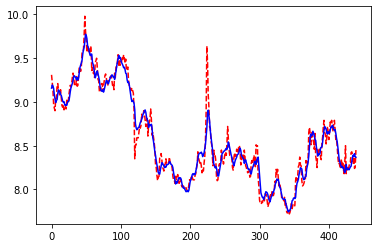

In [100]:
plt.plot(train_real_value_list, 'r--')
plt.plot(train_pred_value_list, 'b-')
plt.show()

In [108]:
print(train_real_value_list[-1])
print(train_pred_value_list[-1])

8.45
8.368321495002997
